In [1]:
# This script needs these libraries to be installed: 
#   numpy, xgboost

import wandb
from wandb.xgboost import WandbCallback
import numpy as np
import xgboost as xgb
import utils
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_percentage_error,mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import itertools
import matplotlib.dates as mdates
import pandas as pd


warnings.filterwarnings('ignore')


# Loading & Preprocessing Data

In [2]:
df = utils.load_data()
df = utils.log_transformation(df)
df = utils.break_datetime(df)
df = df[df['site_id'].isin([1, 6])]
df = utils.nan_weather_filler(df)
df.head()

,building_id,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,sea_level_pressure,wind_direction,wind_speed,log_meter_reading,log_square_feet,year,weekofyear,dayofweek,month,hour
11199,105,2016-01-01 08:00:00,46.1071,1,Education,50623,NaN,5.0,2.2,0.0,...,1022.3,60.0,1.0,3.852424,10.832181,2015,53,5,1,8
11200,106,2016-01-01 08:00:00,0.7492,1,Education,5374,NaN,4.0,2.2,0.0,...,1022.3,60.0,1.0,0.559159,8.589514,2015,53,5,1,8
11201,107,2016-01-01 08:00:00,350.3670,1,Education,97532,2005.0,10.0,2.2,0.0,...,1022.3,60.0,1.0,5.861831,11.487946,2015,53,5,1,8
11202,108,2016-01-01 08:00:00,182.5310,1,Education,81580,1913.0,5.0,2.2,0.0,...,1022.3,60.0,1.0,5.212384,11.309352,2015,53,5,1,8
11203,109,2016-01-01 08:00:00,164.3510,1,Education,56995,1953.0,6.0,2.2,0.0,...,1022.3,60.0,1.0,5.108070,10.950736,2015,53,5,1,8


In [3]:
# encoding 
df = utils.circular_encode(df,'month', 12)
df = utils.label_encode(df,'primary_use')
df.head()

,building_id,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,log_meter_reading,log_square_feet,year,weekofyear,dayofweek,month,hour,month_sin,month_cos,primary_use_encoded
11199,105,2016-01-01 08:00:00,46.1071,1,Education,50623,NaN,5.0,2.2,0.0,...,3.852424,10.832181,2015,53,5,1,8,0.5,0.866025,0
11200,106,2016-01-01 08:00:00,0.7492,1,Education,5374,NaN,4.0,2.2,0.0,...,0.559159,8.589514,2015,53,5,1,8,0.5,0.866025,0
11201,107,2016-01-01 08:00:00,350.3670,1,Education,97532,2005.0,10.0,2.2,0.0,...,5.861831,11.487946,2015,53,5,1,8,0.5,0.866025,0
11202,108,2016-01-01 08:00:00,182.5310,1,Education,81580,1913.0,5.0,2.2,0.0,...,5.212384,11.309352,2015,53,5,1,8,0.5,0.866025,0
11203,109,2016-01-01 08:00:00,164.3510,1,Education,56995,1953.0,6.0,2.2,0.0,...,5.108070,10.950736,2015,53,5,1,8,0.5,0.866025,0


In [4]:
# Add holidays
df = utils.apply_holidays(df)
df.head()

,building_id,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,log_square_feet,year,weekofyear,dayofweek,month,hour,month_sin,month_cos,primary_use_encoded,is_holiday
11199,105,2016-01-01 08:00:00,46.1071,1,Education,50623,NaN,5.0,2.2,0.0,...,10.832181,2015,53,5,1,8,0.5,0.866025,0,1
11200,106,2016-01-01 08:00:00,0.7492,1,Education,5374,NaN,4.0,2.2,0.0,...,8.589514,2015,53,5,1,8,0.5,0.866025,0,1
11201,107,2016-01-01 08:00:00,350.3670,1,Education,97532,2005.0,10.0,2.2,0.0,...,11.487946,2015,53,5,1,8,0.5,0.866025,0,1
11202,108,2016-01-01 08:00:00,182.5310,1,Education,81580,1913.0,5.0,2.2,0.0,...,11.309352,2015,53,5,1,8,0.5,0.866025,0,1
11203,109,2016-01-01 08:00:00,164.3510,1,Education,56995,1953.0,6.0,2.2,0.0,...,10.950736,2015,53,5,1,8,0.5,0.866025,0,1


# XGB Model

In [5]:
features = ['hour','air_temperature','month_sin','month_cos','log_square_feet', 'primary_use_encoded','is_holiday']
target = 'log_meter_reading'

In [6]:
df=df.sort_values(by='timestamp')

# Create WandB Project

In [7]:
wandb.init(project='XGB_Grid_Search', entity='foresquad')

# Define the hyperparameter values for grid search
max_depth_values = [3, 5, 8]
n_estimators_values = [50, 100, 150]
learning_rate_values = [0.05, 0.1]

# Perform grid search
best_params = None
best_mse = float('inf')

# Generate all combinations of hyperparameters
hyperparameter_combinations = list(itertools.product(max_depth_values, n_estimators_values, learning_rate_values))

for params in hyperparameter_combinations:
    max_depth, n_estimators, learning_rate = params

    # Split data for time series
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Initialize metrics
    mse_scores = []

    i = 1
    # Perform time series cross-validation
    for train_index, val_index in tscv.split(df):

        if i==5:
            break;
        
        train_data, val_data = df.iloc[train_index], df.iloc[val_index]
        X_train, y_train = train_data[features], train_data[target]
        X_val, y_val = val_data[features], val_data[target]

        # Train XGBoost model
        model = xgb.XGBRegressor(
            max_depth=max_depth,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            objective='reg:squarederror'  # Specify the appropriate objective for regression
        )
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=False)

        # Make predictions
        y_pred = model.predict(X_val)

        # Calculate mean squared error
        mse = mean_squared_error(y_val, y_pred)
        mse_scores.append(mse)

    # Compute the average MSE over folds
    average_mse = sum(mse_scores) / len(mse_scores)

    # Log hyperparameters and metrics to Weights & Biases
    wandb.log({"max_depth": max_depth, "n_estimators": n_estimators, "learning_rate": learning_rate, "mse": average_mse})

    # Update best hyperparameters if current configuration is better
    if average_mse < best_mse:
        best_mse = average_mse
        best_params = {"max_depth": max_depth, "n_estimators": n_estimators, "learning_rate": learning_rate}
    
    i = i + 1

# Log the best hyperparameters and metrics after grid search
wandb.log({"Best Hyperparameters": best_params, "Best Mean Squared Error": best_mse})
wandb.finish()  # Finish the W&B run to ensure logs are flushed before the script exits


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: guzunturk94 (foresquad). Use `wandb login --relogin` to force relogin


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Mean Squared Error,▁
learning_rate,▁█▁█▁█▁█▁█▁█▁█▁█▁█
max_depth,▁▁▁▁▁▁▄▄▄▄▄▄██████
mse,█▄▄▃▄▂▄▂▁▁▁▁▄▂▂▁▁▁
n_estimators,▁▁▅▅██▁▁▅▅██▁▁▅▅██
Best Mean Squared Error,0.23956
learning_rate,0.1
max_depth,8
mse,0.25649
n_estimators,150


In [8]:
MSE_train = []
R2_train = []
MAE_train = []

MSE_test = []
R2_test = []
MAE_test = []

In [9]:

models = []
tscv = TimeSeriesSplit(n_splits=5)  # You can adjust the number of splits

i = 1
for train_index, test_index in tscv.split(df):
    df_train, df_test = df.iloc[train_index], df.iloc[test_index]
    print('fold :', i)
    print('Train: ',df_train['timestamp'].min(), df_train['timestamp'].max()) 
    print('Test: ',df_test['timestamp'].min(), df_test['timestamp'].max()) 
    i = i + 1 

    X_train = df_train[features]
    X_test = df_test[features]
    y_train = df_train[target]
    y_test = df_test[target]

    XGB = xgb.XGBRegressor(
    objective='reg:squarederror',  # Use 'reg:squarederror' for regression problems
    n_estimators=150,               # Number of boosting rounds (adjust as needed)
    learning_rate=0.1,              # Step size shrinkage to prevent overfitting
    max_depth=5                    # Maximum depth of each tree (adjust as needed)
    )

    XGB.fit(X_train,y_train)
    models.append(XGB)
    
    y_pred_train = XGB.predict(X_train)
    train_error_mse = mean_squared_error(y_train,y_pred_train)
    train_error_r2 = r2_score(y_train,y_pred_train)
    train_error_mae = mean_absolute_error(y_train,y_pred_train)

    print("MSE for train set is: ",train_error_mse)

    print("R2 for train set is: ",train_error_r2)

    print("MAE for train set is: ",train_error_mae)

    y_pred_test = XGB.predict(X_test)
    test_error_mse = mean_squared_error(y_test,y_pred_test)
    test_error_r2 = r2_score(y_test,y_pred_test)
    test_error_mae = mean_absolute_error(y_test,y_pred_test)


    print("MSE for test set is: ",test_error_mse)

    print("R2 for test set is: ",test_error_r2)

    print("MAE for test set is: ",test_error_mae)

    print("--------------------------------")

    MSE_train.append(train_error_mse)
    R2_train.append(train_error_r2)
    MAE_train.append(train_error_mae)

    MSE_test.append(test_error_mse)
    R2_test.append(test_error_r2)
    MAE_test.append(test_error_mae)





fold : 1
Train:  2016-01-01 08:00:00 2016-03-02 16:00:00
Test:  2016-03-02 16:00:00 2016-05-03 09:00:00
MSE for train set is:  0.015064732577552429
R2 for train set is:  0.9888928323506769
MAE for train set is:  0.08871469367897487
MSE for test set is:  0.18432763575881864
R2 for test set is:  0.872401877985859
MAE for test set is:  0.19275912137665982
--------------------------------
fold : 2
Train:  2016-01-01 08:00:00 2016-05-03 09:00:00
Test:  2016-05-03 09:00:00 2016-07-01 13:00:00
MSE for train set is:  0.020865660486994585
R2 for train set is:  0.9851281931403145
MAE for train set is:  0.09700649544103802
MSE for test set is:  0.29241149137104344
R2 for test set is:  0.8372271618469106
MAE for test set is:  0.21241822010442812
--------------------------------
fold : 3
Train:  2016-01-01 08:00:00 2016-07-01 13:00:00
Test:  2016-07-01 13:00:00 2016-08-31 18:00:00
MSE for train set is:  0.03562229821207445
R2 for train set is:  0.9768176605065133
MAE for train set is:  0.1147943191

fold : 1
Train:  2016-01-01 08:00:00 2016-03-02 16:00:00
Test:  2016-03-02 16:00:00 2016-05-03 09:00:00


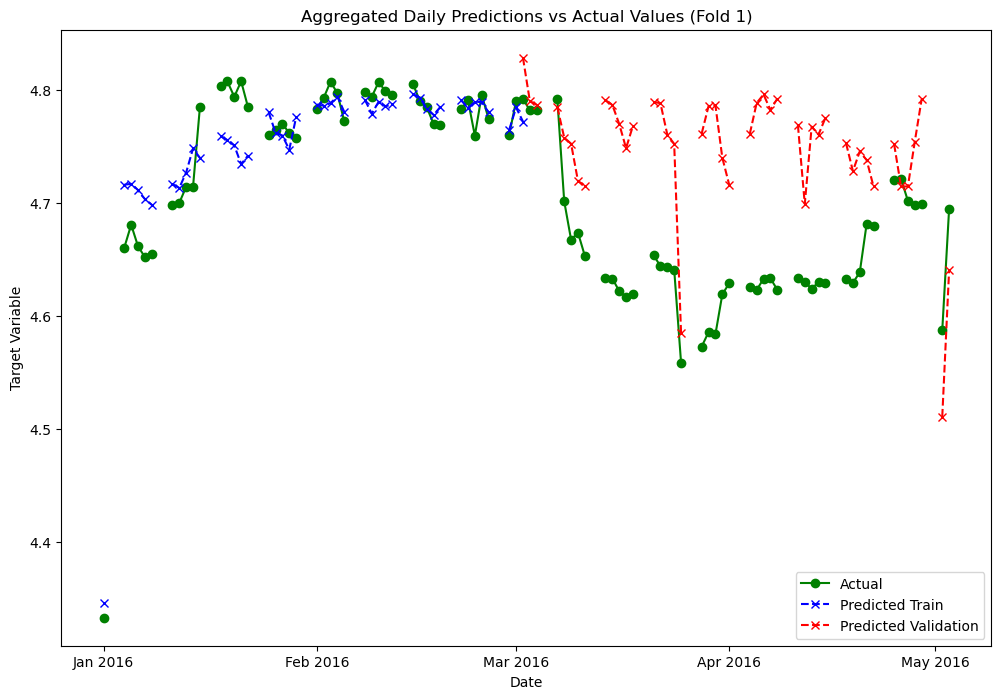

fold : 2
Train:  2016-01-01 08:00:00 2016-05-03 09:00:00
Test:  2016-05-03 09:00:00 2016-07-01 13:00:00


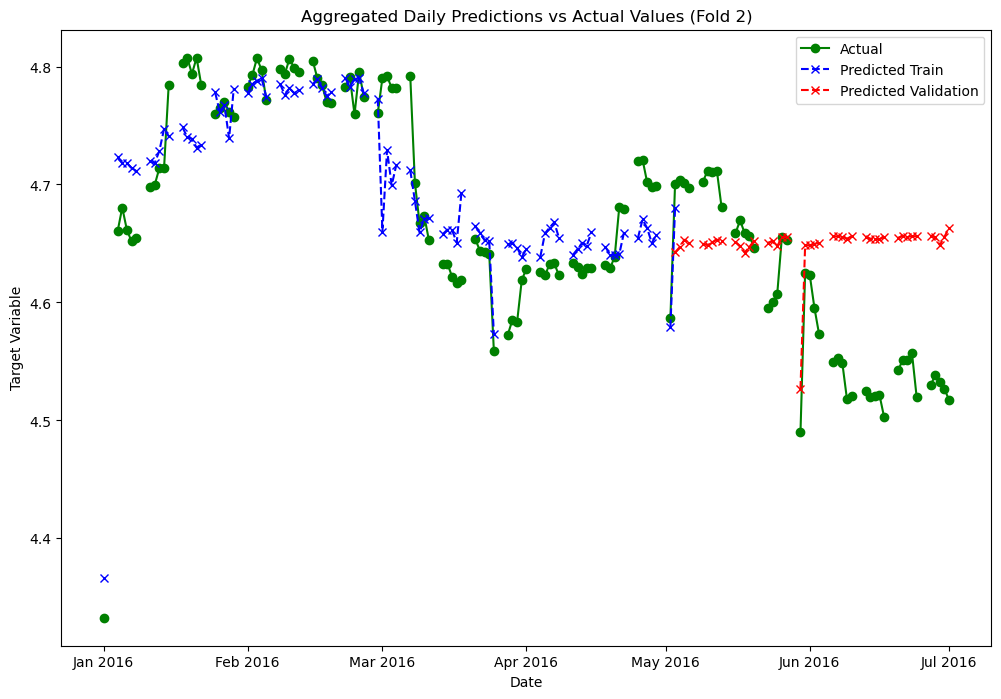

fold : 3
Train:  2016-01-01 08:00:00 2016-07-01 13:00:00
Test:  2016-07-01 13:00:00 2016-08-31 18:00:00


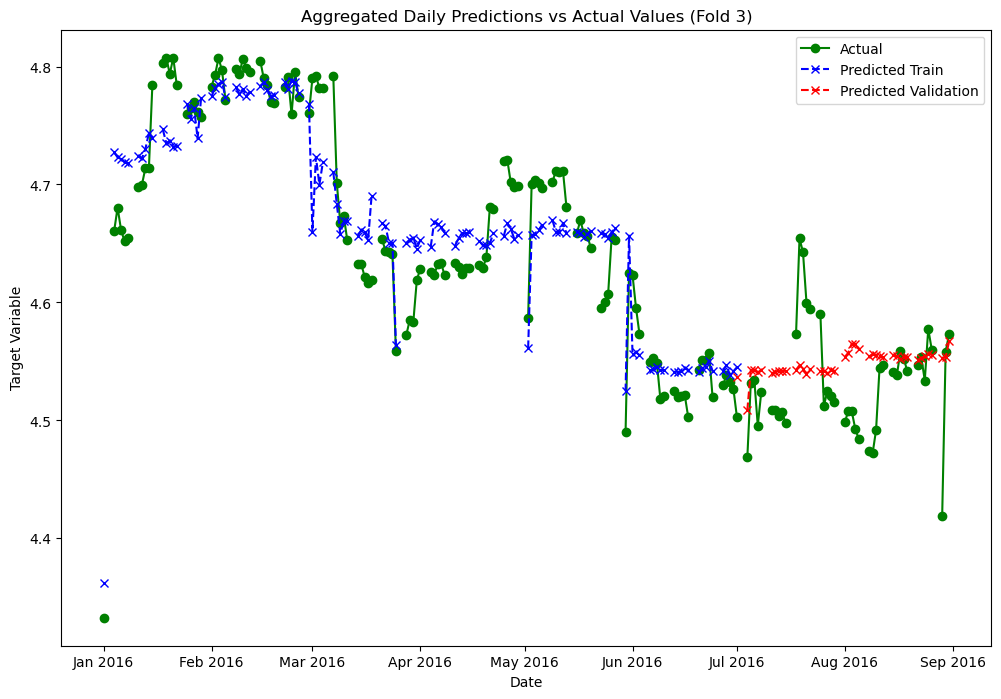

fold : 4
Train:  2016-01-01 08:00:00 2016-08-31 18:00:00
Test:  2016-08-31 18:00:00 2016-11-01 12:00:00


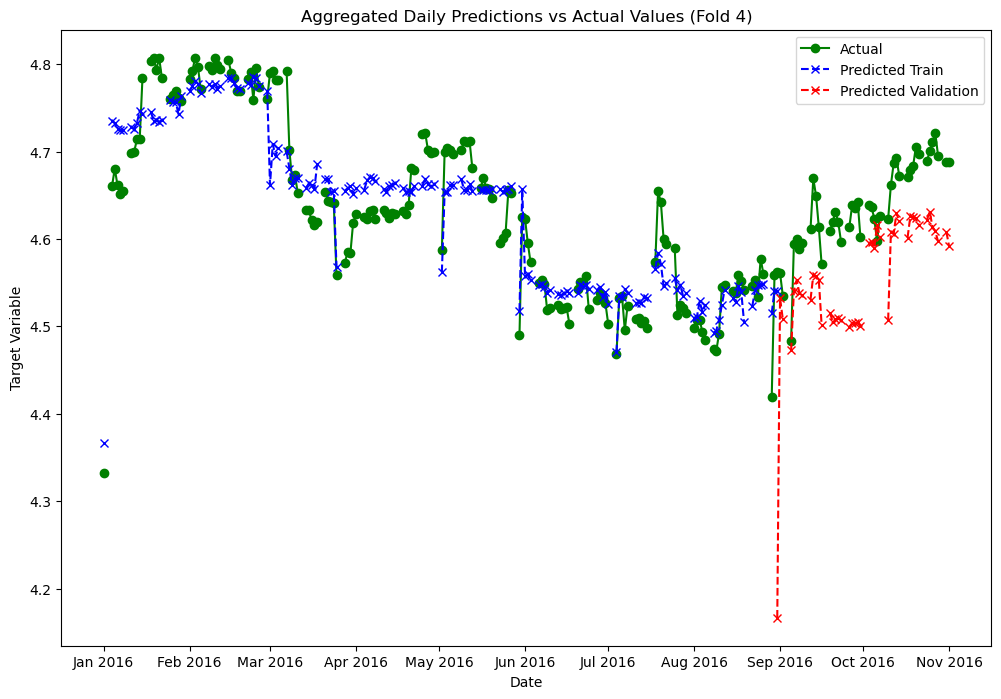

fold : 5
Train:  2016-01-01 08:00:00 2016-11-01 12:00:00
Test:  2016-11-01 12:00:00 2016-12-30 18:00:00


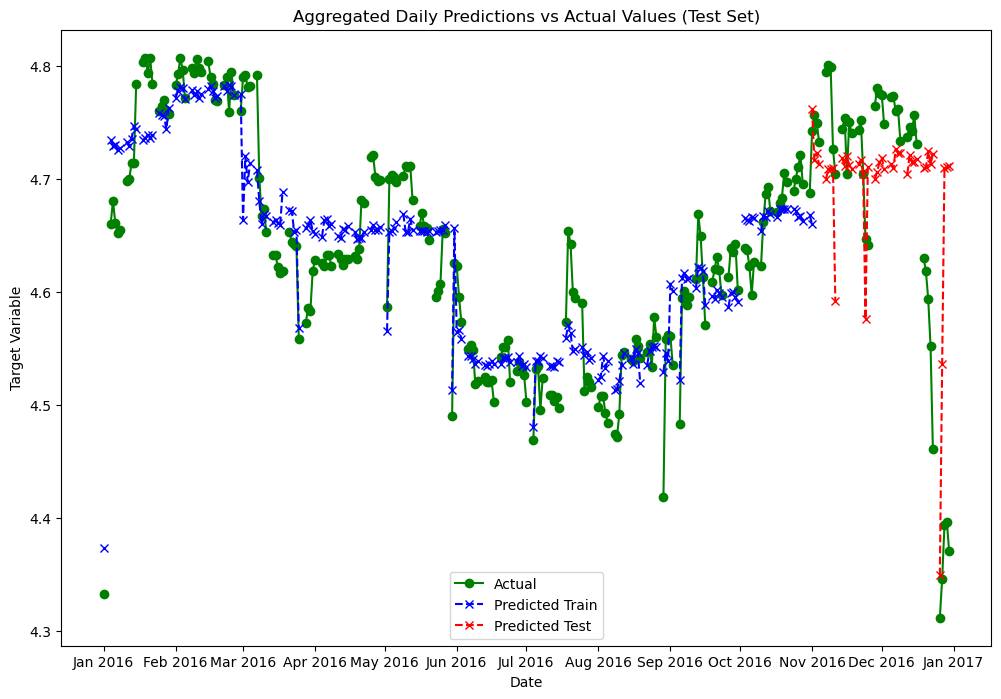

In [10]:
i = 0  # Start fold index from 1

for train_index, test_index in tscv.split(df):
    df_train, df_test = df.iloc[train_index], df.iloc[test_index]
    print('fold :', i+1)
    print('Train: ', df_train['timestamp'].min(), df_train['timestamp'].max()) 
    print('Test: ', df_test['timestamp'].min(), df_test['timestamp'].max()) 

    X_train = df_train[features]
    X_test = df_test[features]
    y_train = df_train[target]
    y_test = df_test[target]

    XGB = models[i]
    i = i+1
    XGB.fit(X_train, y_train)
    
    y_pred_train = XGB.predict(X_train)
    y_pred_test = XGB.predict(X_test)

    # DataFrames to store aggregated values for the current fold
    aggregated_actual_df = pd.concat([pd.DataFrame({'timestamp': df_train['timestamp'], 'actual': y_train}),
                                      pd.DataFrame({'timestamp': df_test['timestamp'], 'actual': y_test})])

    aggregated_predicted_df = pd.concat([pd.DataFrame({'timestamp': df_train['timestamp'], 'predicted_train': y_pred_train}),
                                         pd.DataFrame({'timestamp': df_test['timestamp'], 'predicted_test': y_pred_test})])

    # Group by timestamp and resample on a daily basis
    aggregated_actual_df.set_index('timestamp', inplace=True)
    aggregated_predicted_df.set_index('timestamp', inplace=True)

    aggregated_actual_daily = aggregated_actual_df.resample('D').mean()
    aggregated_predicted_daily = aggregated_predicted_df.resample('D').mean()

    # Plotting aggregated daily predictions for the current fold
    plt.figure(figsize=(12, 8))
    plt.plot(aggregated_actual_daily.index, aggregated_actual_daily['actual'], label='Actual', marker='o', color='green')
    plt.plot(aggregated_predicted_daily.index, aggregated_predicted_daily['predicted_train'], label='Predicted Train', marker='x', linestyle='--', color='blue')
    if (i==5):
        plt.plot(aggregated_predicted_daily.index, aggregated_predicted_daily['predicted_test'], label='Predicted Test', marker='x', linestyle='--', color='red')
        plt.title(f'Aggregated Daily Predictions vs Actual Values (Test Set)')
    else:
        plt.plot(aggregated_predicted_daily.index, aggregated_predicted_daily['predicted_test'], label='Predicted Validation', marker='x', linestyle='--', color='red')
        plt.title(f'Aggregated Daily Predictions vs Actual Values (Fold {i})')
    plt.xlabel('Date')
    plt.ylabel('Target Variable')
    plt.legend()
    # Format x-axis ticks as months
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())    

    plt.show()

    

# Save model for best hyperparameters and for train&test set

In [12]:
utils.save_model(models[4],"XGB_v2")

In [13]:
import joblib
# Save only the trained model to a file
joblib.dump(XGB, 'trained_model.joblib')

['trained_model.joblib']